<a href="https://colab.research.google.com/github/segak2003/MSFT-Stock-Predictor/blob/main/msft_stock_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy

In [ ]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):

    """
    Transform a dataframe into a windowed format suitable for time-series forecasting.

    Parameters:
    dataframe (pd.DataFrame): Source data frame containing the stock prices.
    first_date_str (str): The start date for the analysis in 'YYYY-MM-DD' format.
    last_date_str (str): The end date for the analysis in 'YYYY-MM-DD' format.
    n (int): The size of the window for creating features.

    Returns:
    pd.DataFrame: A new dataframe in a windowed format
    """

    # Convert string dates to datetime objects
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:

        # Extract the relevant data for the current window
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        # Separate the input features and target value
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Calculate the next target date
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True


    # Organize the windowed data into a new dataframe
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)

    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
    ret_df['Target'] = Y

    return ret_df

In [ ]:
def windowed_df_to_date(windowed_df):
    """
    Transforms a windowed DataFrame into date, feature, and target arrays

    - Extracts dates for each target value, useful for time-series analysis.
    - Converts the middle section of the DataFrame to feature array X, representing
      past values for prediction.
    - Isolates the last column as the target array Y, the values to be predicted.
    - Ensures data types are float32 for compatibility with machine learning models.
    """

    np_df = windowed_df.to_numpy()
    dates = np_df[:, 0]
    mid_matrix = np_df[:, 1:-1]
    X = mid_matrix.reshape((len(dates), mid_matrix.shape[1]))

    Y = np_df[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

In [ ]:
def str_to_datetime(str):
    """
    This function takes the string versions of the date
    (which we pass into the fuction as str) and
    returns the associated date time for that string
    """
    split = str.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year = year, month = month, day=day)

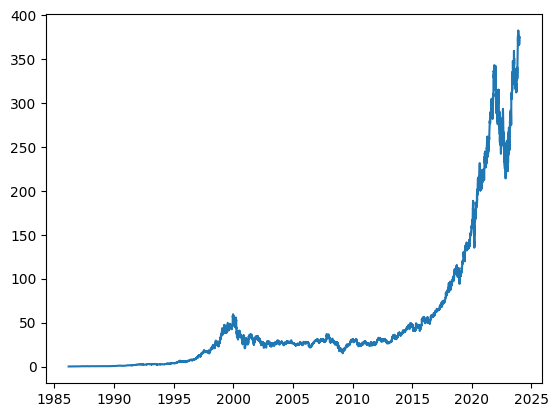

In [ ]:
#------- Main execution startes in the proceeding cells ------####

# Read and preprocess the dataset
df = pd.read_csv('MSFT.csv')

# Keep only the relevant columns
df = df[['Date', 'Close']]

# Convert the date string to datetime object for easier manipulation
df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')

# Plot the closing prices over time
plt.plot(df.index, df['Close'])


flag 0
flag 1
flag 2
flag 3
(252,) (252, 3) (252,)


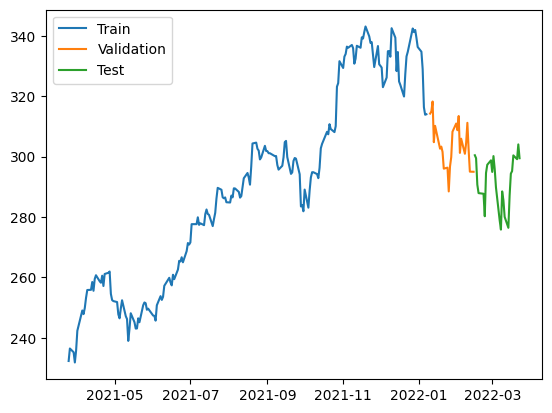

In [ ]:
# Dataset here: https://finance.yahoo.com/quote/MSFT/history/?guccounter=1


# Prepare the dataset for the windowed approach
windowed_df = df_to_windowed_df(df, '2021-03-25',
                                    '2022-03-23',
                                    n=3)

# Convert the windowed dataframe to train, validation, and test sets
dates, X, y = windowed_df_to_date(windowed_df)
print(dates.shape, X.shape, y.shape)
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

# Split the data into training, validation, and testing sets
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

# Plot the training, validation, and test data
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
#----- traning the model with the dataset  -----#


# Define the architecture of the LSTM (Long Short-Term Memory) model
model = Sequential([layers.Input((3, 1)),                 # Input layer: Expects input shape of (3, 1) (3 time steps with 1 feature each)
                    layers.LSTM(64),                      # LSTM layer with 64 units.
                    layers.Dense(32, activation='relu'),  # Dense layer with 32 neurons and ReLU activation
                    layers.Dense(32, activation='relu'),  # Another Dense layer, helps to learn complex patterns
                    layers.Dense(1)])                     # Output layer with a single neuron to predict a continuous value

# Compile the model with mean squared error loss and the Adam optimizer
model.compile(loss='mse',                           # Mean Squared Error
              optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
              metrics=['mean_absolute_error'])      # Monitoring mean absolute error as a metric

# Fit the model on the training data
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 2s 78ms/step - loss: 85075.1250 - mean_absolute_error: 289.9391 - val_loss: 92752.2891 - val_mean_absolute_error: 304.4656
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 84789.0547 - mean_absolute_error: 289.4463 - val_loss: 92490.9219 - val_mean_absolute_error: 304.0361
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 84578.6875 - mean_absolute_error: 289.0827 - val_loss: 92332.1172 - val_mean_absolute_error: 303.7748
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 84451.3906 - mean_absolute_error: 288.8622 - val_loss: 92224.0312 - val_mean_absolute_error: 303.5969
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 84353.6641 - mean_absolute_error: 288.6922 - val_loss: 92118.7266 - val_mean_absolute_error: 303.4234
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 84243.3125 - mean_absolute_error: 288.5013 - val_loss: 91985.03

7/7 [==============================] - 0s 2ms/step


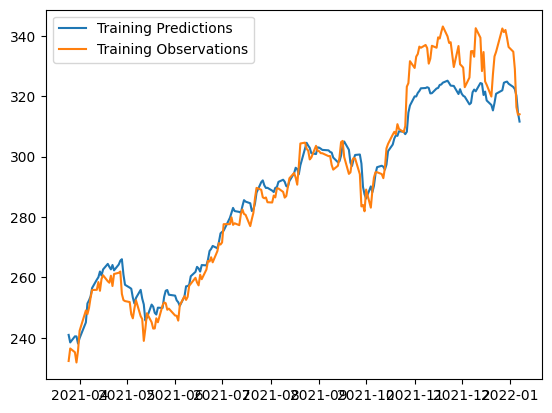

In [ ]:
#------ Generate and plot predictions for the training set ------#

train_predictions = model.predict(X_train).flatten()   # Generate predictions for the training data

plt.plot(dates_train, train_predictions)               # Plot the predictions
plt.plot(dates_train, y_train)                         # Plot the actual training data for comparison
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 17ms/step


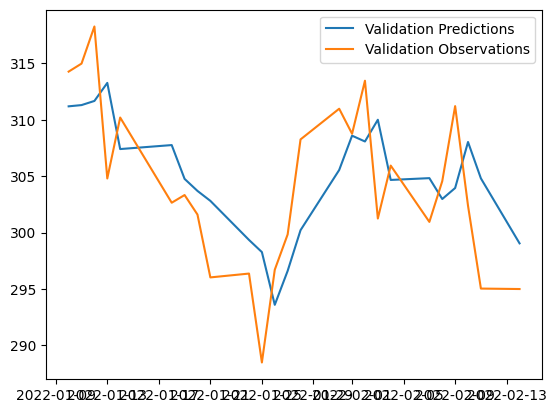

In [ ]:
#------  Generate and plot predictions for the validation set  ------#

val_predictions = model.predict(X_val).flatten()      # Generate predictions for the validation data

plt.plot(dates_val, val_predictions)                  # Plot the validation predictions
plt.plot(dates_val, y_val)                            # Plot the actual validation data for comparison
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 23ms/step


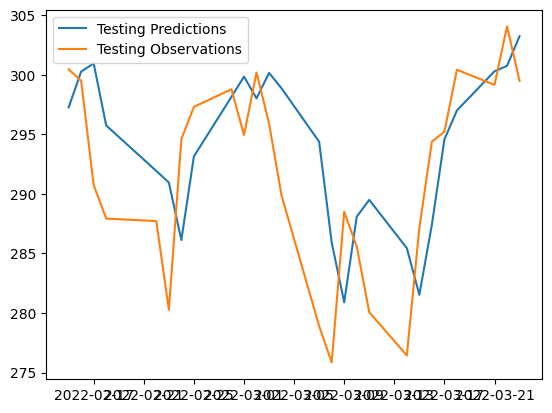

In [ ]:
#-----  Generate and plot predictions for the test set  ------#

test_predictions = model.predict(X_test).flatten()     # Generate predictions for the test data

plt.plot(dates_test, test_predictions)                 # Plot the test predictions
plt.plot(dates_test, y_test)                           # Plot the actual test data for comparison
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
# Generating recursive predictions for the model

recursive_predictions = []
recursive_dates=np.concatenate([dates_val, dates_test])       # Combine validation and test dates for prediction
last_window = deepcopy(X_train[-1])              # Start with the last window of training data


# Iteratively predict the next value using the latest predictions
for target_date in recursive_dates:

    # Predict the next value based on the last window of data
    next_prediction=model.predict(np.array([last_window[-3:]])).flatten()
    recursive_predictions.append(next_prediction)            # Append the prediction to the list

    # Update the last window to include the new prediction (for next iteration)
    last_window = np.concatenate([last_window[-2:], np.array(next_prediction)])

print(recursive_predictions)

1/1 [==============================] - 0s 19ms/step
[array([311.61884], dtype=float32), array([310.04926], dtype=float32), array([308.88235], dtype=float32), array([308.00662], dtype=float32), array([307.33987], dtype=float32), array([306.8276], dtype=float32), array([306.4312], dtype=float32), array([306.1228], dtype=float32), array([305.88187], dtype=float32), array([305.693], dtype=float32), array([305.54462], dtype=float32), array([305.4278], dtype=float32), array([305.3357], dtype=float32), array([305.26303], dtype=float32), array([305.20557], dtype=float32), array([305.16016], dtype=float32), array([305.12424], dtype=float32), array([305.09576], dtype=float32), array([305.07324], dtype=float32), array([305.0554], dtype=float32), array([305.04123], dtype=float32), array([305.03006], dtype=float32), array([305.02115], dtype=float32), array([305.01413], dtype=float32), array([305.00854], dtype=float32), array([305.00415], dtype=float32), array([305.00064], dtype=float32), array([304

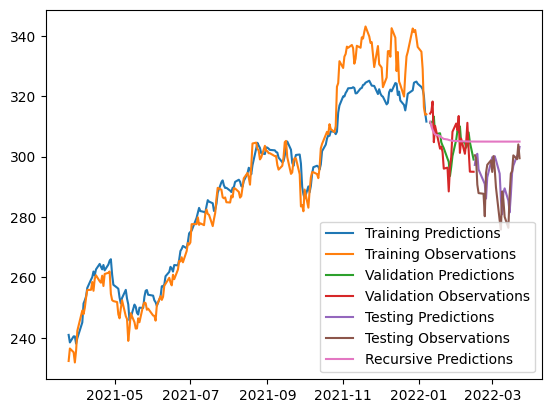

In [ ]:
#------- Plotting all predictions and actual observations  -------#
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)

plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])